<a href="https://colab.research.google.com/github/yang-su2000/Authorship-Identification-with-NLP/blob/main/run_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("drive/MyDrive/Colab Notebooks/Authorship Identification/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load C50 Dataset

In [ ]:
from os import listdir
from os.path import isfile, isdir, join
import numpy as np

author_names = [name for name in listdir('C50/C50train/') if isdir(join('C50/C50train/', name))]
print('There are', len(author_names), 'authors (both train and test), the first 3:', author_names[:3])

train_article_names = [[article_name for article_name in listdir('C50/C50train/' + author_name + '/') if isfile(join('C50/C50train/' + author_name + '/', article_name))]
                  for author_name in author_names]
print('There are', len(train_article_names[0]), '(train) articles written by the first author')
test_article_names = [[article_name for article_name in listdir('C50/C50test/' + author_name + '/') if isfile(join('C50/C50test/' + author_name + '/', article_name))]
                  for author_name in author_names]
print('There are', len(test_article_names[0]), '(test) articles written by the first author')

train_articles = np.empty((2500, 2), dtype=object)
for i, author_name in enumerate(author_names):
  for j, article_name in enumerate(train_article_names[i]):
    file_path = 'C50/C50train/' + author_name + '/' + article_name
    with open(file_path, 'r') as f:
      train_articles[i * len(author_names) + j, 0] = author_name
      train_articles[i * len(author_names) + j, 1] = f.read()
print('The shape of train articles is', train_articles.shape)

test_articles = np.empty((2500, 2), dtype=object)
for i, author_name in enumerate(author_names):
  for j, article_name in enumerate(test_article_names[i]):
    file_path = 'C50/C50test/' + author_name + '/' + article_name
    with open(file_path, 'r') as f:
      test_articles[i * len(author_names) + j, 0] = author_name
      test_articles[i * len(author_names) + j, 1] = f.read()
print('The shape of test articles is', test_articles.shape)

In [ ]:
print('The average length of text of an article in training set is', np.mean([len(content.split()) for content in train_articles[:,1]]), 
      'and in test set is', np.mean([len(content.split()) for content in test_articles[:,1]]))

The average length of text of an article in training set is 501.77 and in test set is 509.5508


In [ ]:
import pandas as pd

train_df = pd.DataFrame(data=train_articles, columns=['author','content'])
train_df.to_csv('C50/train.csv', index=False)
test_df = pd.DataFrame(data=test_articles, columns=['author','content'])
test_df.to_csv('C50/test.csv', index=False)

### Load C50 Dataset (if already loaded)

- this (original dataset) is 50 train - 50 test split

In [2]:
import pandas as pd

train_df = pd.read_csv('C50/train.csv')
test_df = pd.read_csv('C50/test.csv')

- this is 90 train - 10 test split

In [ ]:
random_seed = 42
test_frac = 0.1
train_df = pd.concat([train_df, test_df])
test_df = train_df.sample(frac=test_frac, random_state=random_seed)
train_df = train_df.drop(test_df.index)

In [3]:
train_df.head()

,author,content
0,BernardHickey,Westpac Banking Corp Ltd is expected to report...
1,BernardHickey,"Australia's second-largest bank, Westpac Banki..."
2,BernardHickey,Airline giant British Airways Plc (BA) is unli...
3,BernardHickey,An official inquiry into Australia's financial...
4,BernardHickey,World yeast and spices giant Burns Philp &amp;...


### Load "All the News" 1 Dataset

In [26]:
import pandas as pd

random_seed = 42
train_df = pd.read_csv('All the News/articles1.csv')
train_df = train_df[(train_df.publication == 'Breitbart')]
top10_authors = train_df[['author','id']].groupby('author').count().sort_values(by='id', ascending=False).head(10).reset_index() # this == what the paper proposed
print('The authors are', top10_authors.author.values)
train_df = pd.merge(train_df, top10_authors[['author']], on='author', how='right')
train_df = train_df.groupby(by='author').sample(500, random_state=random_seed)
train_df.shape

The authors are ['Breitbart News' 'Pam Key' 'Charlie Spiering' 'Jerome Hudson'
 'John Hayward' 'Daniel Nussbaum' 'AWR Hawkins' 'Ian Hanchett'
 'Joel B. Pollak' 'Alex Swoyer']


(5000, 10)

### Preprocessing

In [4]:
!pip install transformers
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 6.7 MB/s 
     |████████████████████████████████| 163 kB 71.2 MB/s 
     |████████████████████████████████| 7.6 MB 48.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 6.7 MB/s 


In [27]:
import torch
import numpy as np
from sklearn import preprocessing
from transformers import DistilBertTokenizer, BertTokenizer, DebertaTokenizer

random_seed = 42

# if C50 split 50-50
test_frac = 0

# if NOT C50 split 50-50
test_frac = 0.15
test_df = train_df.sample(frac=test_frac, random_state=random_seed)
train_df = train_df.drop(test_df.index).reset_index()
test_df = test_df.reset_index()

le = preprocessing.LabelEncoder()
le.fit(train_df['author'])

train_df['author_id'] = le.transform(train_df['author']).astype(int)
test_df['author_id'] = le.transform(test_df['author']).astype(int)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [6]:
def debug():
  text = tokenizer("Commonwealth _ of Australia (_) managing", padding='max_length', max_length = 32, truncation=True, return_tensors="pt")
  print(text)
  mask_val = tokenizer.vocab.get('_')
  text['attention_mask'] = torch.where(text['input_ids'] == mask_val, 0, text['attention_mask'])
  print(text)

debug()

{'input_ids': tensor([[ 101, 5663, 1035, 1997, 2660, 1006, 1035, 1007, 6605,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}
{'input_ids': tensor([[ 101, 5663, 1035, 1997, 2660, 1006, 1035, 1007, 6605,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}


In [28]:
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer

def mask_contents(percent, method):
  vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=False, stop_words='english')
  vectorizer.fit(pd.concat([train_df['content'], valid_df['content']]))
  X_train = vectorizer.transform(train_df['content'])
  X_valid = vectorizer.transform(valid_df['content'])
  X_test = vectorizer.transform(test_df['content'])
  feat_names = vectorizer.get_feature_names_out()
  feat_idf = vectorizer.idf_

  def mask_content(X, df):
    idxs = None
    if method == 'all':
      rows, cols, vals = sparse.find(X)
      k = min(int(X.nnz * percent), X.nnz - 1)
      idxs = np.argpartition(vals, -k)[-k:]
    elif method == 'df':
      rows, cols, vals = sparse.find(X)
      k = int(len(feat_names) * percent)
      mask_idxs = feat_idf.argpartition(k)[:k]
      mask = [0] * len(feat_idf)
      for mask_idx in mask_idxs:
        mask[mask_idx] = 1
      idxs = [i for i, col in enumerate(cols) if mask[col]]

    mask_rows, mask_cols = rows[idxs], cols[idxs]
    mask_mat = [[] for _ in range(X.shape[0])]
    for row, col in zip(mask_rows, mask_cols):
      mask_mat[row].append(feat_names[col])
    ret = []
    for i, mask_row in enumerate(mask_mat):
      text = df['content'][i]
      for mask_word in mask_row:
        text = text.replace(mask_word, '_')
      ret.append(text)
    return ret

  train_df['masked_content'] = mask_content(X_train, train_df)
  valid_df['masked_content'] = mask_content(X_valid, valid_df)
  test_df['masked_content'] = mask_content(X_test, test_df)

In [29]:
print('The average length of text of an article in training set is', np.mean([len(content.split()) for content in train_df['content'].values]), 
      'and in test set is', np.mean([len(content.split()) for content in test_df['content'].values]))

The average length of text of an article in training set is 423.20305882352943 and in test set is 442.7626666666667


In [30]:
random_seed = 42
valid_frac = 0.1 / (1 - test_frac)
valid_df = train_df.sample(frac=valid_frac, random_state=random_seed)
train_df = train_df.drop(valid_df.index).reset_index()
valid_df = valid_df.reset_index()

### Dataset Class

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = df['author_id'].values
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['masked_content']]
        # add attention mask
        mask_val = tokenizer.vocab.get('_')
        for text in self.texts:
          text['attention_mask'] = torch.where(text['input_ids'] == mask_val, 0, text['attention_mask'])

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

### Model Class

In [32]:
from torch import nn
from transformers import DistilBertForSequenceClassification, BertForSequenceClassification, DebertaForSequenceClassification, get_linear_schedule_with_warmup

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super().__init__()

        self.bert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(le.classes_))
        # self.dropout = nn.Dropout(dropout)
        # self.linear = nn.Linear(768, 50)
        # self.relu = nn.ReLU()

    def forward(self, input_id, labels=None):

        # pooled_output, = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        # pooled_output = pooled_output[:,0,:]
        # dropout_output = self.dropout(pooled_output)
        # linear_output = self.linear(dropout_output)
        # final_layer = self.relu(linear_output)
        # print(input_id.shape, labels.shape)
        final_layer = self.bert(input_id, labels=labels)

        return final_layer

### Training

In [33]:
# !git clone https://gist.github.com/NTT123/4596e5533e573c8ceab2f319ab5d36a2 jslog
import random
import math
import time
from jslog.jslogger import JSLogger

logger = JSLogger('train/valid loss', ['train', 'valid'])
logger_ = JSLogger('train/valid accuracy', ['train', 'valid'])

In [41]:
from torch.optim import AdamW
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=100,
        num_training_steps=len(train_dataloader) * epochs,
    )

    if use_cuda:

            print('cuda version', torch.__version__)
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0
            model.train()

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                # mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, train_label)
                
                # batch_loss = criterion(output, train_label.long())
                batch_loss = output.loss
                total_loss_train += batch_loss.item()
                
                acc = (output.logits.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
                lr_scheduler.step()
            
            total_acc_val = 0
            total_loss_val = 0
            model.eval()

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, val_label)

                    # batch_loss = criterion(output, val_label.long())
                    batch_loss = output.loss
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.logits.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .4f} \
                | Train Accuracy: {total_acc_train / len(train_data): .4f} \
                | Val Loss: {total_loss_val / len(val_data): .4f} \
                | Val Accuracy: {total_acc_val / len(val_data): .4f}')
            
            logger.log(epoch_num + 1, {'train': total_loss_train / len(train_data), 'valid': total_loss_val / len(val_data)})
            logger_.log(epoch_num + 1, {'train': total_acc_train / len(train_data), 'valid': total_acc_val / len(val_data)})

logger.show()
logger_.show() 
pd.options.display.max_colwidth = 100            
EPOCHS = 10
LR = 2e-5
model = BertClassifier()
print('There are', sum(p.numel() for p in model.parameters()), 'parameters')

mask_contents(0, method='df')
print(train_df['masked_content'])
              
train(model, train_df, valid_df, LR, EPOCHS)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

There are 66961162 parameters
0       Carly Fiorina released a statement via email in which she said the Ninth Circuit decision is a c...
1       Former Assemblyman and current congressional candidate Tim Donnelly believes Lt. Governor Gavin ...
2       On Tuesday    Hunter Jackson was suspended for seven days after bringing an empty . 22 shell cas...
3       Republican presidential hopeful Donald Trump used Facebook to release a new ad yesterday warning...
4       The NRA’s Annual Meetings and Exhibits, held in Louisville, Kentucky, May   produced a “$53 mill...
                                                       ...                                                 
3745    In a preview clip of an interview set to air on Fox News Channel’s Tuesday broadcast of “Fox  Fr...
3746    Monday at the   League Conference, FBI Director James Comey said law enforcement “officers and d...
3747    Tuesday at a press gathering on the campaign trail in Raleigh, NC, Sen. Ted Cruz ( ) responded t..

100%|██████████| 469/469 [03:28<00:00,  2.24it/s]


Epochs: 1 | Train Loss:  0.1570                 | Train Accuracy:  0.6045                 | Val Loss:  0.0569                 | Val Accuracy:  0.8740


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 469/469 [03:28<00:00,  2.25it/s]


Epochs: 2 | Train Loss:  0.0444                 | Train Accuracy:  0.8941                 | Val Loss:  0.0402                 | Val Accuracy:  0.8860


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 469/469 [03:27<00:00,  2.26it/s]


Epochs: 3 | Train Loss:  0.0226                 | Train Accuracy:  0.9480                 | Val Loss:  0.0343                 | Val Accuracy:  0.9060


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 469/469 [03:27<00:00,  2.26it/s]


Epochs: 4 | Train Loss:  0.0116                 | Train Accuracy:  0.9741                 | Val Loss:  0.0315                 | Val Accuracy:  0.9140


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 469/469 [03:27<00:00,  2.26it/s]


Epochs: 5 | Train Loss:  0.0053                 | Train Accuracy:  0.9899                 | Val Loss:  0.0345                 | Val Accuracy:  0.9120


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 469/469 [03:28<00:00,  2.25it/s]


Epochs: 6 | Train Loss:  0.0028                 | Train Accuracy:  0.9965                 | Val Loss:  0.0332                 | Val Accuracy:  0.9220


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 42%|████▏     | 197/469 [01:27<02:01,  2.24it/s]


KeyboardInterrupt: ignored

### Evaluate

In [42]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=32)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    model.eval()
    
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              # mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, test_label)

              acc = (output.logits.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .4f}')
    
print(test_df['masked_content'])
evaluate(model, test_df)

0      Republican presidential nominee Donald Trump is moving up further in the L. A. Times daily track...
1      On Monday’s broadcast of “The Five,” Fox News analyst Juan Williams stated that members of the m...
2      During an interview on CNN on Tuesday, Senator Ted Cruz ( ) stated that the nomination of Judge ...
3      Glenn Thrush, a solid progressive, writes at Politico how Hillary Clinton is   and boring compar...
4      Donald Trump is firing back after Hillary Clinton’s statement on calling half of Trump’s support...
                                                      ...                                                 
745    On Friday’s broadcast of the Fox Business Network’s “Risk  Reward,” Shawn Moran, the Vice Presid...
746    GOP frontrunner Donald Trump touted his love for Mormons during his campaign rally Friday night ...
747    Donald Trump suggested that he and Hillary Clinton should take a drug test before the next debat...
748    Presumptive Democrat nominee H

### Saliency Map

In [ ]:
def get_saliency_map(model, df):
    input_text = [tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt") for text in df['content']]
    input = input_text[0]
    print(input.shape)
    for param in model.parameters():
        param.requires_grad = False
    model.eval()
    # input.unsqueeze_(0)
    input.requires_grad = True
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())
    return slc

input_slc = get_saliency_map(model, train_df)
print(input_slc.shape)
input_slc

### SHAP

In [43]:
import shap
import scipy as sp

def f(x):
  tv = torch.tensor([tokenizer.encode(v, padding='max_length', \
    max_length=512, truncation=True) for v in x]).cuda()
  outputs = model(tv)[0].detach().cpu().numpy()
  scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
  val = sp.special.logit(scores[:,1]) # use one vs rest logit units
  return val

explainer = shap.Explainer(f, tokenizer)
shap_values = explainer(train_df['masked_content'][:2], fixed_context=1, batch_size=32)

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 3it [00:25, 12.69s/it]


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


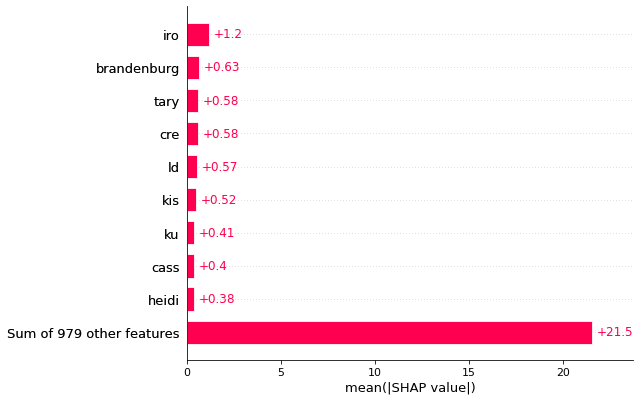

In [16]:
shap.plots.bar(shap_values.abs.mean(0)) # default

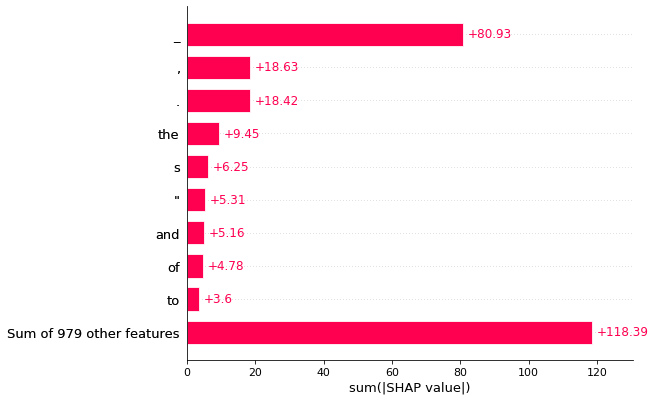

In [17]:
shap.plots.bar(shap_values.abs.sum(0))

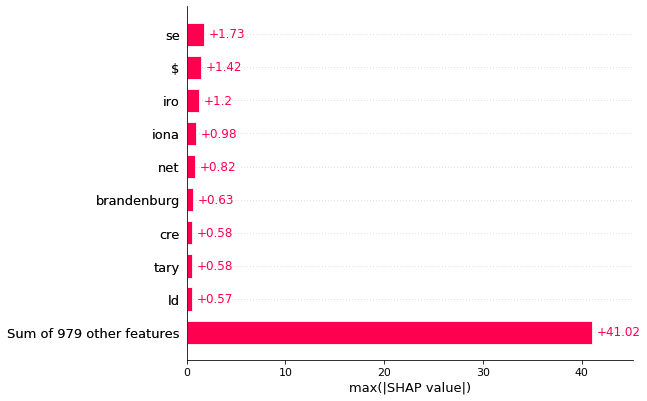

In [18]:
shap.plots.bar(shap_values.abs.max(0))

In [44]:
shap.plots.text(shap_values)